# Regression: Closed Form vs GD vs SGD

In this notebook we compare:
- Closed-form Ordinary Least Squares
- Gradient Descent (GD)
- Stochastic Gradient Descent (SGD)

on a synthetic linear regression problem.



In [3]:
import numpy as np
import matplotlib.pyplot as plt

from optimization_double_descent.data.synthetic import RegressionDataset
from optimization_double_descent.models.linear import LinearModel
from optimization_double_descent.objectives.least_squares import LeastSquares
from optimization_double_descent.solvers.gradient_descent import GradientDescent
from optimization_double_descent.solvers.stochastic_gradient_descent import StochasticGradientDescent


findfont: Font family ['STIXGeneral'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXGeneral'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXGeneral'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXGeneral'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXNonUnicode'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXNonUnicode'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXNonUnicode'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXSizeOneSym'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXSizeTwoSym'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXSizeThreeSym'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXSizeFourSym'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXSizeFiveSym'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmsy10'] not

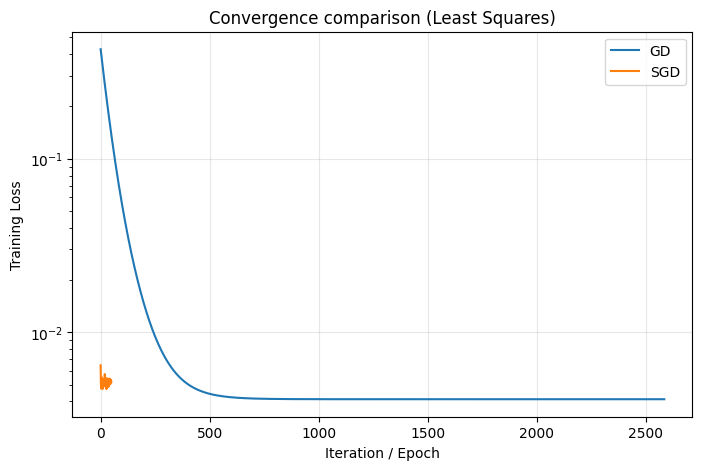

In [5]:

from optimization_double_descent.data.synthetic import RegressionDataset

ds = RegressionDataset(
    n_samples=500,
    n_features=50,
    noise_std=0.1,
    seed=0,
)

X_train, y_train, X_test, y_test = ds.generate()
n_features = X_train.shape[1]

# OLS
objective = LeastSquares()


# Closed-form solution
w_closed = np.linalg.pinv(X_train) @ y_train

train_mse_closed = objective.loss(X_train, y_train, w_closed)
test_mse_closed = objective.loss(X_test, y_test, w_closed)

train_mse_closed, test_mse_closed


#GD

model_gd = LinearModel(n_features=n_features)

gd = GradientDescent(
    lr=1e-2,
    max_iter=5000,
    tol=1e-6,
    record_history=True,
)

history_gd = gd.solve(
    model_gd,
    objective,
    X_train,
    y_train,
)

w_gd = model_gd.w

train_mse_gd = objective.loss(X_train, y_train, w_gd)
test_mse_gd = objective.loss(X_test, y_test, w_gd)

train_mse_gd, test_mse_gd


#SGD
from optimization_double_descent.solvers.stochastic_gradient_descent import StochasticGradientDescent

model_sgd = LinearModel(n_features=n_features)

sgd = StochasticGradientDescent(
    lr=1e-2,
    batch_size=1,
    epochs=50,
    shuffle=True,
    record_history=True,
    seed=0,
)

history_sgd = sgd.solve(
    model_sgd,
    objective,
    X_train,
    y_train,
)

w_sgd = model_sgd.w

train_mse_sgd = objective.loss(X_train, y_train, w_sgd)
test_mse_sgd = objective.loss(X_test, y_test, w_sgd)

train_mse_sgd, test_mse_sgd

#SIGKRISI
import pandas as pd

pd.DataFrame(
    {
        "Train MSE": [
            train_mse_closed,
            train_mse_gd,
            train_mse_sgd,
        ],
        "Test MSE": [
            test_mse_closed,
            test_mse_gd,
            test_mse_sgd,
        ],
    },
    index=["Closed-form", "GD", "SGD"],
)

#PLOTS
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))

plt.plot(
    [h["loss"] for h in history_gd],
    label="GD",
)

plt.plot(
    [h["loss"] for h in history_sgd],
    label="SGD",
)

plt.yscale("log")
plt.xlabel("Iteration / Epoch")
plt.ylabel("Training Loss")
plt.title("Convergence comparison (Least Squares)")
plt.legend()
plt.grid(alpha=0.3)
plt.show()



In [6]:

import pandas as pd

pd.DataFrame(
    {
        "Train MSE": [
            train_mse_closed,
            train_mse_gd,
            train_mse_sgd,
        ],
        "Test MSE": [
            test_mse_closed,
            test_mse_gd,
            test_mse_sgd,
        ],
    },
    index=["Closed-form", "GD", "SGD"],
)


,Train MSE,Test MSE
Closed-form,0.004115,0.005194
GD,0.004115,0.005194
SGD,0.005172,0.005151


Capacity Sweep  GD / SGD

In [13]:
from tqdm import tqdm

p_grid = range(5, 301, 5)

results = {
    "p": [],
    "test_closed": [],
    "test_gd": [],
    "test_sgd": [],
}

for p in tqdm(p_grid):

    ds = RegressionDataset(
        n_samples=300,
        n_features=p,
        noise_std=0.1,
        seed=0,
    )

    X_train, y_train, X_test, y_test = ds.generate()
    n_features = X_train.shape[1]

    # objective
    objective = LeastSquares()

    # -------- Closed form
    w_closed = np.linalg.pinv(X_train) @ y_train
    train_mse_closed = objective.loss(X_train, y_train, w_closed)
    test_closed = objective.loss(X_test, y_test, w_closed)

    # -------- GD
    model_gd = LinearModel(n_features=n_features)
    gd = GradientDescent(lr=1e-2, max_iter=3000)
    gd.solve(model_gd, objective, X_train, y_train)
    test_gd = objective.loss(X_test, y_test, model_gd.w)

    # -------- SGD with convergence loop
    model_sgd = LinearModel(n_features=n_features)
    sgd = StochasticGradientDescent(
        lr=5e-3,
        batch_size=32,
        epochs=1,
        shuffle=True,
        seed=0,
    )

    # run SGD until it reaches ~closed-form training loss
    for _ in range(300):  # max 300 epochs
        sgd.solve(model_sgd, objective, X_train, y_train)
        if objective.loss(X_train, y_train, model_sgd.w) <= 1.1 * train_mse_closed:
            break

    test_sgd = objective.loss(X_test, y_test, model_sgd.w)

    # -------- store results
    results["p"].append(p)
    results["test_closed"].append(test_closed)
    results["test_gd"].append(test_gd)
    results["test_sgd"].append(test_sgd)


100%|██████████| 60/60 [00:09<00:00,  6.13it/s]


  0%|          | 0/60 [00:00<?, ?it/s]

100%|██████████| 60/60 [00:08<00:00,  7.06it/s]


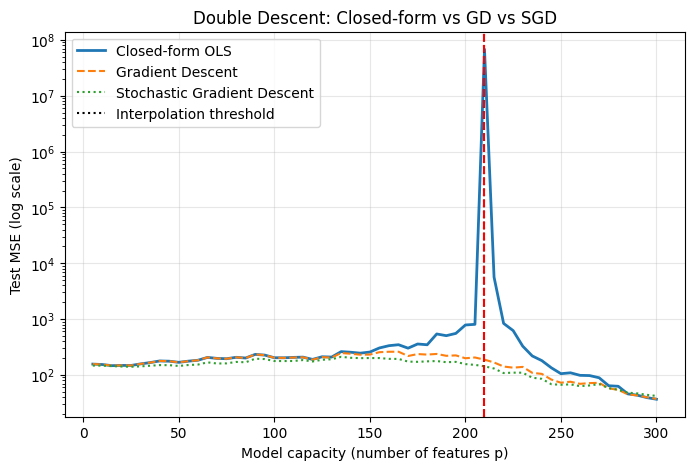

In [26]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from optimization_double_descent.data.synthetic import RegressionDataset
from optimization_double_descent.models.linear import LinearModel
from optimization_double_descent.objectives.least_squares import LeastSquares
from optimization_double_descent.solvers.gradient_descent import GradientDescent
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

from optimization_double_descent.models.linear import LinearModel
from optimization_double_descent.objectives.least_squares import LeastSquares
from optimization_double_descent.solvers.gradient_descent import GradientDescent
from optimization_double_descent.solvers.stochastic_gradient_descent import StochasticGradientDescent

# --- FixedDataset class ---
class FixedDataset:
    def __init__(self, n_samples, n_features_max, noise_std, test_ratio, seed):
        rng = np.random.default_rng(seed)
        self.w_true = rng.normal(size=n_features_max)
        X_full = rng.normal(size=(n_samples, n_features_max))
        eps = rng.normal(scale=noise_std, size=n_samples)
        y_full = X_full @ self.w_true + eps
        split = int(n_samples * (1 - test_ratio))
        self.X_train_full = X_full[:split]
        self.y_train = y_full[:split]
        self.X_test_full = X_full[split:]
        self.y_test = y_full[split:]

    def get(self, p):
        return (
            self.X_train_full[:, :p],
            self.y_train,
            self.X_test_full[:, :p],
            self.y_test,
        )

# --- Parameters ---
n_samples = 300
test_ratio = 0.3
p_grid = range(5, 301, 5)
objective = LeastSquares()

# --- Create fixed dataset once ---
dataset = FixedDataset(
    n_samples=n_samples,
    n_features_max=max(p_grid),
    noise_std=0.1,
    test_ratio=test_ratio,
    seed=0,
)

# --- Storage ---
results = {
    "p": [],
    "train_closed": [],
    "train_gd": [],
    "train_sgd": [],
    "test_closed": [],
    "test_gd": [],
    "test_sgd": [],
}

# --- Capacity sweep ---
for p in tqdm(p_grid):

    X_train, y_train, X_test, y_test = dataset.get(p)

    # === Closed-form ===
    w_closed = np.linalg.pinv(X_train) @ y_train
    train_closed = objective.loss(X_train, y_train, w_closed)
    test_closed = objective.loss(X_test, y_test, w_closed)

    # === GD ===
    model_gd = LinearModel(n_features=p)
    gd = GradientDescent(lr=1e-2, max_iter=3000)
    gd.solve(model_gd, objective, X_train, y_train)
    train_gd = objective.loss(X_train, y_train, model_gd.w)
    test_gd = objective.loss(X_test, y_test, model_gd.w)

    # === SGD with convergence ===
    model_sgd = LinearModel(n_features=p)
    sgd = StochasticGradientDescent(
        lr=5e-3,
        batch_size=32,
        epochs=1,
        shuffle=True,
        seed=0,
    )
    for _ in range(300):  # max 300 epochs
        sgd.solve(model_sgd, objective, X_train, y_train)
        if objective.loss(X_train, y_train, model_sgd.w) <= 1.05 * train_closed:
            break
    train_sgd = objective.loss(X_train, y_train, model_sgd.w)
    test_sgd = objective.loss(X_test, y_test, model_sgd.w)

    # === Store ===
    results["p"].append(p)
    results["train_closed"].append(train_closed)
    results["train_gd"].append(train_gd)
    results["train_sgd"].append(train_sgd)
    results["test_closed"].append(test_closed)
    results["test_gd"].append(test_gd)
    results["test_sgd"].append(test_sgd)
    

import matplotlib.pyplot as plt
import numpy as np

p = np.array(results["p"])

plt.figure(figsize=(8, 5))

plt.plot(
    p,
    results["test_closed"],
    label="Closed-form OLS",
    linewidth=2,
)

plt.plot(
    p,
    results["test_gd"],
    label="Gradient Descent",
    linestyle="--",
)

plt.plot(
    p,
    results["test_sgd"],
    label="Stochastic Gradient Descent",
    linestyle=":",
)

# interpolation threshold
n_train = int(0.7 * 300)   # επειδή default test_ratio=0.3
plt.axvline(
    n_train,
    color="k",
    linestyle=":",
    label="Interpolation threshold",
)

plt.yscale("log")
plt.xlabel("Model capacity (number of features p)")
plt.ylabel("Test MSE (log scale)")
plt.title("Double Descent: Closed-form vs GD vs SGD")
plt.legend()
plt.grid(alpha=0.3)

plt.axvline(
    n_train,
    color="red",
    linestyle="--",
    label="p = n_train"
)


plt.show()


# PLOT DOUBLE DESCENT TEST MSE


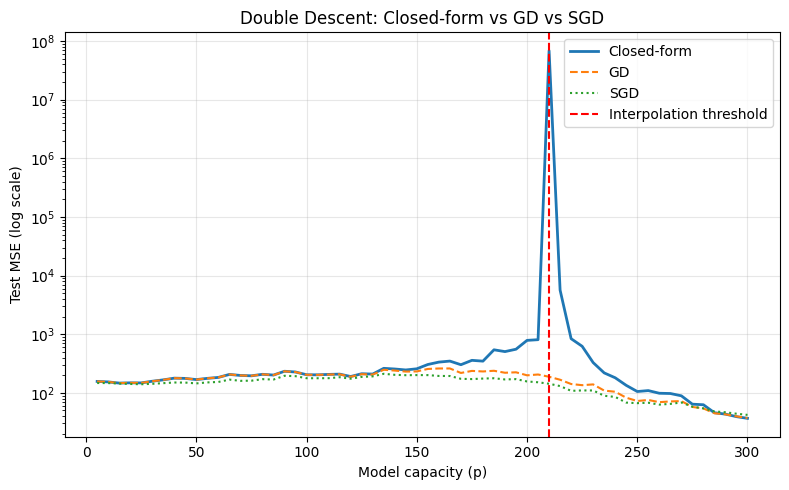

In [21]:
p = np.array(results["p"])

plt.figure(figsize=(8, 5))

plt.plot(p, results["test_closed"], label="Closed-form", linewidth=2)
plt.plot(p, results["test_gd"], label="GD", linestyle="--")
plt.plot(p, results["test_sgd"], label="SGD", linestyle=":")

plt.axvline(x=int(n_samples * (1 - test_ratio)), color="red", linestyle="--", label="Interpolation threshold")
plt.yscale("log")
plt.xlabel("Model capacity (p)")
plt.ylabel("Test MSE (log scale)")
plt.title("Double Descent: Closed-form vs GD vs SGD")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


# Training Error

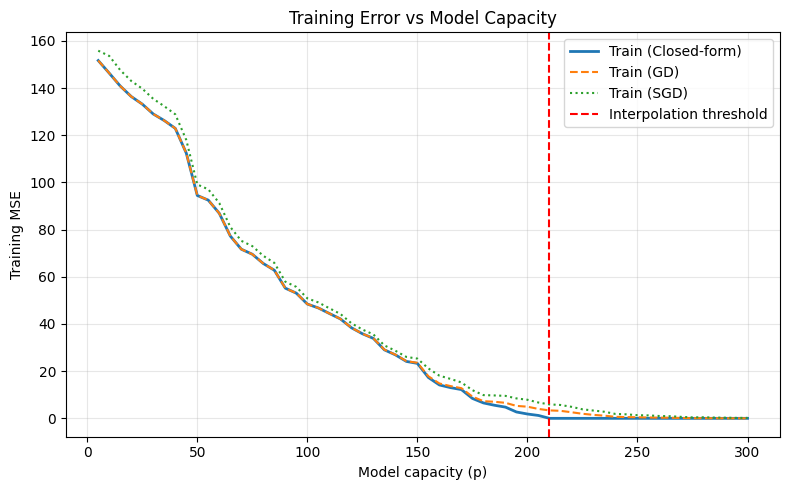

In [27]:
plt.figure(figsize=(8, 5))

plt.plot(p, results["train_closed"], label="Train (Closed-form)", linewidth=2)
plt.plot(p, results["train_gd"], label="Train (GD)", linestyle="--")
plt.plot(p, results["train_sgd"], label="Train (SGD)", linestyle=":")

plt.axvline(x=int(n_samples * (1 - test_ratio)), color="red", linestyle="--", label="Interpolation threshold")
plt.xlabel("Model capacity (p)")
plt.ylabel("Training MSE")
plt.title("Training Error vs Model Capacity")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


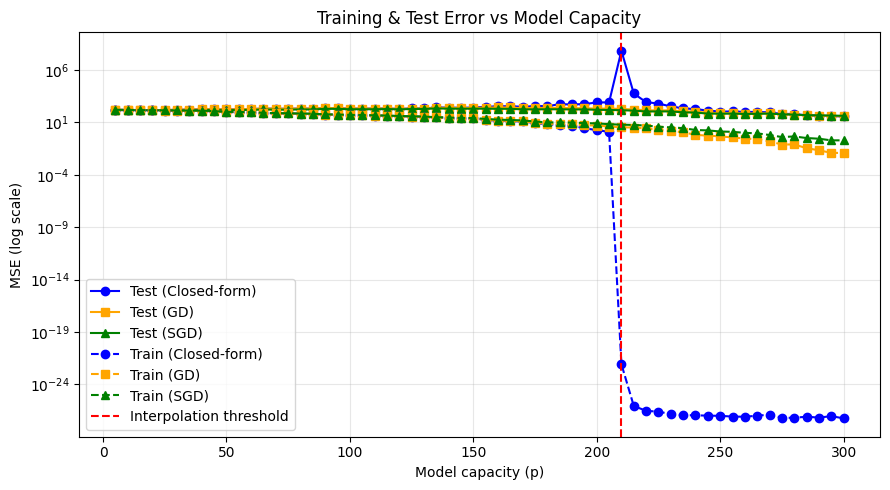

In [29]:
plt.figure(figsize=(9, 5))

# Test
plt.semilogy(p, results["test_closed"], marker="o", color="blue", label="Test (Closed-form)")
plt.semilogy(p, results["test_gd"], marker="s", color="orange", label="Test (GD)")
plt.semilogy(p, results["test_sgd"], marker="^", color="green", label="Test (SGD)")

# Train
plt.semilogy(p, results["train_closed"], linestyle="--", marker="o", color="blue", label="Train (Closed-form)")
plt.semilogy(p, results["train_gd"], linestyle="--", marker="s", color="orange", label="Train (GD)")
plt.semilogy(p, results["train_sgd"], linestyle="--", marker="^", color="green", label="Train (SGD)")

plt.axvline(x=int(n_samples * (1 - test_ratio)), color="red", linestyle="--", label="Interpolation threshold")
plt.xlabel("Model capacity (p)")
plt.ylabel("MSE (log scale)")
plt.title("Training & Test Error vs Model Capacity")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


100%|██████████| 60/60 [00:08<00:00,  6.71it/s]


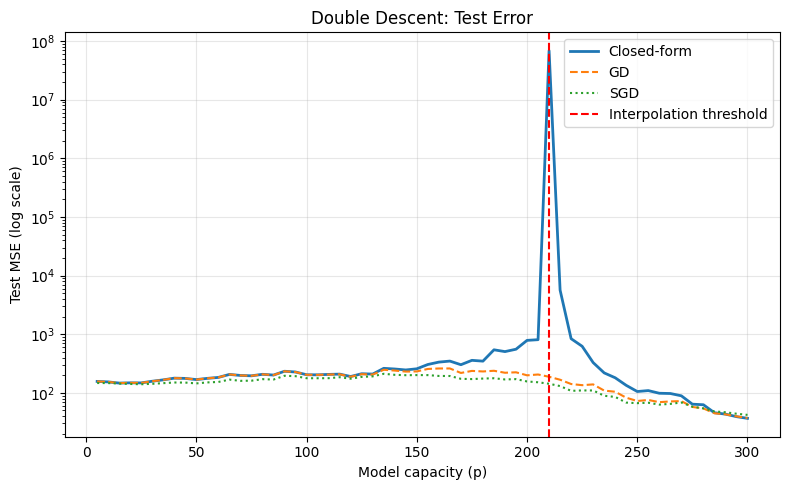

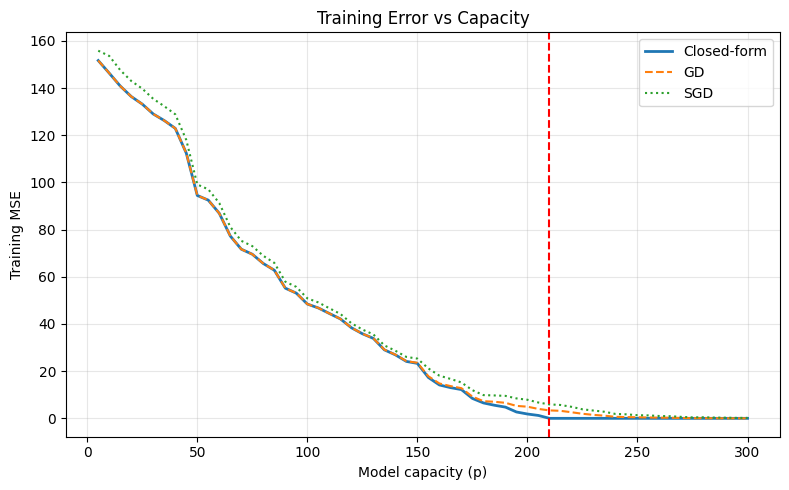

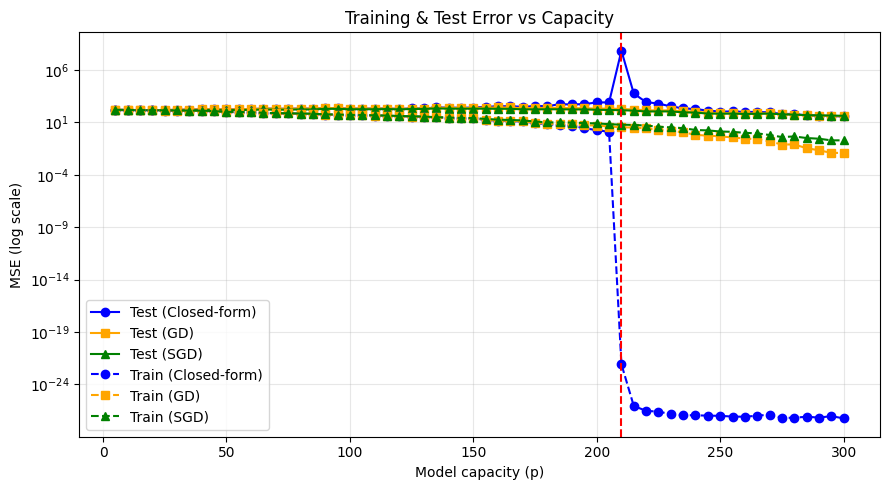

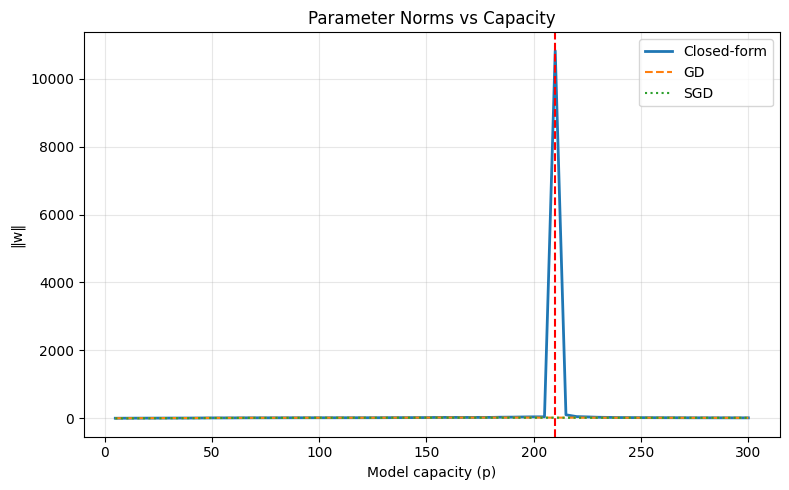

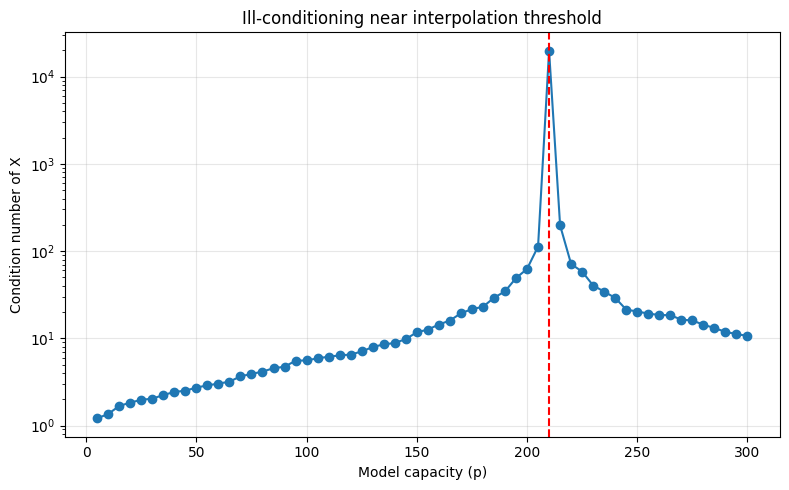

In [30]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

from optimization_double_descent.models.linear import LinearModel
from optimization_double_descent.objectives.least_squares import LeastSquares
from optimization_double_descent.solvers.gradient_descent import GradientDescent
from optimization_double_descent.solvers.stochastic_gradient_descent import StochasticGradientDescent


# ============================================================
# FIXED DATASET
# ============================================================

class FixedDataset:
    def __init__(self, n_samples, n_features_max, noise_std, test_ratio, seed):
        rng = np.random.default_rng(seed)

        self.w_true = rng.normal(size=n_features_max)
        X_full = rng.normal(size=(n_samples, n_features_max))
        eps = rng.normal(scale=noise_std, size=n_samples)
        y_full = X_full @ self.w_true + eps

        split = int(n_samples * (1 - test_ratio))
        self.X_train_full = X_full[:split]
        self.y_train = y_full[:split]
        self.X_test_full = X_full[split:]
        self.y_test = y_full[split:]

    def get(self, p):
        return (
            self.X_train_full[:, :p],
            self.y_train,
            self.X_test_full[:, :p],
            self.y_test,
        )


# ============================================================
# PARAMETERS
# ============================================================

n_samples = 300
test_ratio = 0.3
p_grid = range(5, 301, 5)
objective = LeastSquares()

dataset = FixedDataset(
    n_samples=n_samples,
    n_features_max=max(p_grid),
    noise_std=0.1,
    test_ratio=test_ratio,
    seed=0,
)

# Storage
results = {
    "p": [],
    "train_closed": [],
    "train_gd": [],
    "train_sgd": [],
    "test_closed": [],
    "test_gd": [],
    "test_sgd": [],
    "norm_closed": [],
    "norm_gd": [],
    "norm_sgd": [],
    "cond": [],
}


# ============================================================
# CAPACITY SWEEP
# ============================================================

for p in tqdm(p_grid):

    X_train, y_train, X_test, y_test = dataset.get(p)

    # Condition number
    cond = np.linalg.cond(X_train)

    # === Closed-form ===
    w_closed = np.linalg.pinv(X_train) @ y_train
    train_closed = objective.loss(X_train, y_train, w_closed)
    test_closed = objective.loss(X_test, y_test, w_closed)

    # === GD ===
    model_gd = LinearModel(n_features=p)
    gd = GradientDescent(lr=1e-2, max_iter=3000)
    gd.solve(model_gd, objective, X_train, y_train)
    w_gd = model_gd.w
    train_gd = objective.loss(X_train, y_train, w_gd)
    test_gd = objective.loss(X_test, y_test, w_gd)

    # === SGD with convergence ===
    model_sgd = LinearModel(n_features=p)
    sgd = StochasticGradientDescent(
        lr=5e-3,
        batch_size=32,
        epochs=1,
        shuffle=True,
        seed=0,
    )

    for _ in range(300):
        sgd.solve(model_sgd, objective, X_train, y_train)
        if objective.loss(X_train, y_train, model_sgd.w) <= 1.05 * train_closed:
            break

    w_sgd = model_sgd.w
    train_sgd = objective.loss(X_train, y_train, w_sgd)
    test_sgd = objective.loss(X_test, y_test, w_sgd)

    # Store
    results["p"].append(p)
    results["train_closed"].append(train_closed)
    results["train_gd"].append(train_gd)
    results["train_sgd"].append(train_sgd)
    results["test_closed"].append(test_closed)
    results["test_gd"].append(test_gd)
    results["test_sgd"].append(test_sgd)
    results["norm_closed"].append(np.linalg.norm(w_closed))
    results["norm_gd"].append(np.linalg.norm(w_gd))
    results["norm_sgd"].append(np.linalg.norm(w_sgd))
    results["cond"].append(cond)


# ============================================================
# PLOTS
# ============================================================

p = np.array(results["p"])
interp = int(n_samples * (1 - test_ratio))


# 1. Test Error (Double Descent)
plt.figure(figsize=(8, 5))
plt.plot(p, results["test_closed"], label="Closed-form", linewidth=2)
plt.plot(p, results["test_gd"], label="GD", linestyle="--")
plt.plot(p, results["test_sgd"], label="SGD", linestyle=":")
plt.axvline(interp, color="red", linestyle="--", label="Interpolation threshold")
plt.yscale("log")
plt.xlabel("Model capacity (p)")
plt.ylabel("Test MSE (log scale)")
plt.title("Double Descent: Test Error")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


# 2. Training Error
plt.figure(figsize=(8, 5))
plt.plot(p, results["train_closed"], label="Closed-form", linewidth=2)
plt.plot(p, results["train_gd"], label="GD", linestyle="--")
plt.plot(p, results["train_sgd"], label="SGD", linestyle=":")
plt.axvline(interp, color="red", linestyle="--")
plt.xlabel("Model capacity (p)")
plt.ylabel("Training MSE")
plt.title("Training Error vs Capacity")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


# 3. Train + Test in one plot
plt.figure(figsize=(9, 5))

# Test
plt.semilogy(p, results["test_closed"], marker="o", color="blue", label="Test (Closed-form)")
plt.semilogy(p, results["test_gd"], marker="s", color="orange", label="Test (GD)")
plt.semilogy(p, results["test_sgd"], marker="^", color="green", label="Test (SGD)")

# Train
plt.semilogy(p, results["train_closed"], linestyle="--", marker="o", color="blue", label="Train (Closed-form)")
plt.semilogy(p, results["train_gd"], linestyle="--", marker="s", color="orange", label="Train (GD)")
plt.semilogy(p, results["train_sgd"], linestyle="--", marker="^", color="green", label="Train (SGD)")

plt.axvline(interp, color="red", linestyle="--")
plt.xlabel("Model capacity (p)")
plt.ylabel("MSE (log scale)")
plt.title("Training & Test Error vs Capacity")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


# 4. Parameter Norms
plt.figure(figsize=(8, 5))
plt.plot(p, results["norm_closed"], label="Closed-form", linewidth=2)
plt.plot(p, results["norm_gd"], label="GD", linestyle="--")
plt.plot(p, results["norm_sgd"], label="SGD", linestyle=":")
plt.axvline(interp, color="red", linestyle="--")
plt.xlabel("Model capacity (p)")
plt.ylabel("‖w‖")
plt.title("Parameter Norms vs Capacity")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


# 5. Condition Number
plt.figure(figsize=(8, 5))
plt.semilogy(p, results["cond"], marker="o")
plt.axvline(interp, color="red", linestyle="--")
plt.xlabel("Model capacity (p)")
plt.ylabel("Condition number of X")
plt.title("Ill-conditioning near interpolation threshold")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


#  Double Descent in Linear Regression — Experimental Analysis

This experiment investigates the double descent phenomenon in linear regression using three solvers:

- **Closed-form solution** (minimum-norm interpolator)
- **Gradient Descent (GD)**
- **Stochastic Gradient Descent (SGD)**

We sweep model capacity \( p \) across the underparameterized, interpolation, and overparameterized regimes, and measure:

- Test and training error
- Parameter norms
- Condition number of the design matrix

All results are based on a fixed synthetic dataset with controlled noise, fixed ground truth \( w^* \), and a consistent train/test split. This ensures that all observed effects are due to model capacity and optimization dynamics — not data variability.

---

## 1.  Test Error — Double Descent

 
- The **Closed-form** curve exhibits a sharp spike in test error near the interpolation threshold \( p = n_{\text{train}} \), followed by a decline.
- **GD** and **SGD** show smoother curves with no dramatic spike.

**Why it happens:**  
- Near \( p = n \), the model transitions from underfitting to interpolation.  
- The closed-form solution fits the training data exactly, but becomes sensitive to noise due to ill-conditioning — leading to a spike in test error.
- GD and SGD implicitly regularize the solution, favoring lower-norm weights and avoiding the spike.

**Theory match:**  
- This is the canonical double descent curve.  
- The spike is expected from variance amplification at the interpolation threshold.  
- The smoother behavior of GD/SGD confirms implicit regularization.

---

## 2.  Training Error vs Capacity

 
- All methods reduce training error as capacity increases.
- Closed-form reaches near-zero error before the interpolation threshold.
- GD and especially SGD converge more slowly, requiring higher capacity to interpolate.

**Why it happens:**  
- Closed-form directly solves the least squares problem.
- GD and SGD require iterative convergence, which is slower for high-dimensional or ill-conditioned problems.

**Theory match:**  
 - Confirms that interpolation is achievable for all methods given enough capacity.  
 - Highlights optimization dynamics and convergence behavior.

---

## 3.  Train + Test Error (Unified View)

 
- Clear separation between training and test error near the interpolation threshold.
- Closed-form shows a spike in test error while training error remains low.
- GD and SGD maintain a smaller gap due to regularization.

**Why it happens:**  
- The spike in test error is due to overfitting and sensitivity to noise.
- GD/SGD avoid this by not fully interpolating the noise.

**Theory match:**  
 - Visualizes the bias–variance tradeoff.  
 - Matches theoretical predictions of generalization behavior across regimes.

---

## 4.  Parameter Norms

 
- Closed-form shows a sharp peak in \( \|w\| \) near the interpolation threshold.
- GD and SGD maintain low, stable norms across all capacities.

**Why it happens:**  
- The closed-form solution explodes in norm when fitting noisy data exactly.
- GD and SGD favor minimum-norm solutions due to their optimization path.

**Theory match:**  
 - Confirms implicit bias of iterative methods.  
 - Matches theoretical results on norm explosion and regularization.

---

## 5.  Condition Number of \( X \)

 
- A sharp spike in the condition number near \( p = n \).
- Indicates numerical instability and near-singularity of the design matrix.

**Why it happens:**  
- As \( p \to n \), the columns of \( X \) become nearly linearly dependent.
- This leads to ill-conditioning and unstable solutions.

**Theory match:**  
 - Matches random matrix theory predictions.  
 - Explains why test error spikes and parameter norms explode near interpolation.

---


##  Conclusion

This experiment successfully reproduces the double descent phenomenon and its associated diagnostics.  
All observed behaviors — test error spike, norm explosion, ill-conditioning, and regularization effects — align with theoretical expectations.

The use of a fixed dataset ensures clean comparisons across solvers and capacities.  
Closed-form, GD, and SGD each reveal distinct behaviors that reflect their optimization and generalization properties.

This setup provides a rigorous foundation for further exploration, including spectral analysis, classification, and implicit bias studies.
